# 3/18/21 - 3-phase fit to G5585328_3234.

## Experiment Outline : phase1_nlive = 200, phase1_tolerance = 0.5, phase2_nlive = 200 (source mask), phase2_tolerance = 0.5, phase3_nlive = 300, phase3_tolerance = 0.25, facc=0.3 for all phases, use effective radius from GAMA DR3 Sersic Photometry catalog (including errors) and upper limit (effective radius + error), 3 position, threshold=1.0

## Instance for lens centre into phase 2 and phase 3. Don't take the instance for the ellipticity and effective radius. Set same max effective radius.

In [4]:
### libraries
%matplotlib inline
# set workspace path
from pyprojroot import here
workspace_path = str(here())#'/data/sknabel/autolens_workspace'
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import matplotlib.pyplot as plt
from autoconf import conf
import autolens as al
import autolens.plot as aplt
import autofit as af
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.stats import sigma_clip as clip
from os import path
import time

# set datetime variable
datetime = time.strftime("%d%m%y")

# paths
autoz_path = '/data/sknabel/autoz_lens_model/'
file_path = f'{autoz_path}files/'
csv_path = f'{file_path}csv/'
fits_path = f'{file_path}fits/'
png_path = f'{autoz_path}visuals/png/'
pdf_path = f'{autoz_path}visuals/pdf/'

/data/sknabel/autoz_lens_model
Working Directory has been set to `/data/sknabel/autoz_lens_model`


In [4]:
# this should be constant across experiments

gama_id = 585328
links_id = 3234
experiment_number=2

# set up for input
#print('GAMA ID?')
#gama_id = int(input())
#print('LinKS ID?')
#links_id = int(input())
#print('Experiment #?')
#experiment_number = int(input())
#print('Shall we have a go?')
#input()

object_folder = f'{fits_path}G{gama_id}_{links_id}/'
output_folder = f'{autoz_path}output/G{gama_id}_{links_id}/'

# load object data table
links = pd.read_csv(f'{csv_path}/latest/links_sample_latest.csv')
lens_galaxy_data = links[links.GAMA_ID == gama_id]
zlens=lens_galaxy_data.zlens.values
zsource=lens_galaxy_data.zsource.values
einstein_radius=np.mean([lens_galaxy_data.theta_e_pm.values, lens_galaxy_data.theta_e_sis.values]) # take average of einstein radius estimates for prior
print(f'Lens and source redshifts at {zlens} and {zsource}.')
print(f'Einstein radius prior: {einstein_radius}')

# effective radius and error from DR3 sersic catalog
hdul = fits.open(f'{fits_path}SersicCatSDSS.fits')
hdul.verify('fix')
data = hdul[1].data
#print(data.columns)
#print(data.CATAID)
candidate = data[data.CATAID == gama_id]
re_r = candidate.GALRE_r[0]
re_r_err = candidate.GALREERR_r[0]
re_g = candidate.GALRE_g[0]
re_g_err = candidate.GALREERR_g[0]

print(re_r, re_r_err, re_g, re_g_err)


Lens and source redshifts at [0.20466271] and [0.78874117].
Einstein radius prior: 1.0876736377169312
2.5114477 0.0574944 2.9118743 0.1916028


Plotting r-band


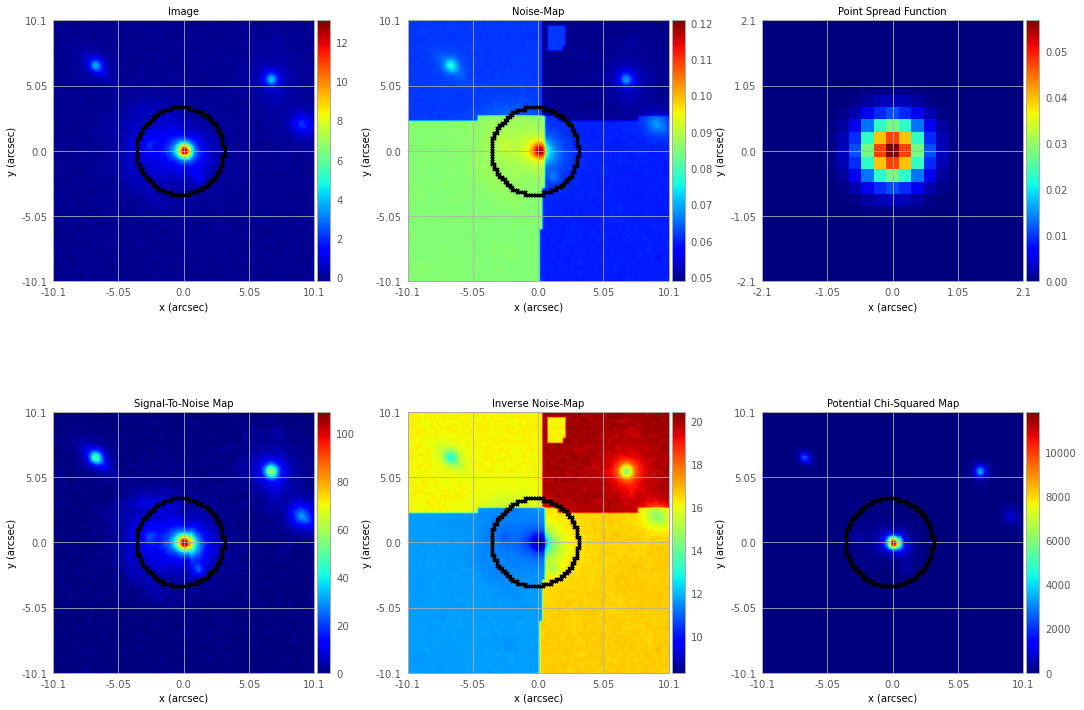

Plotting g-band


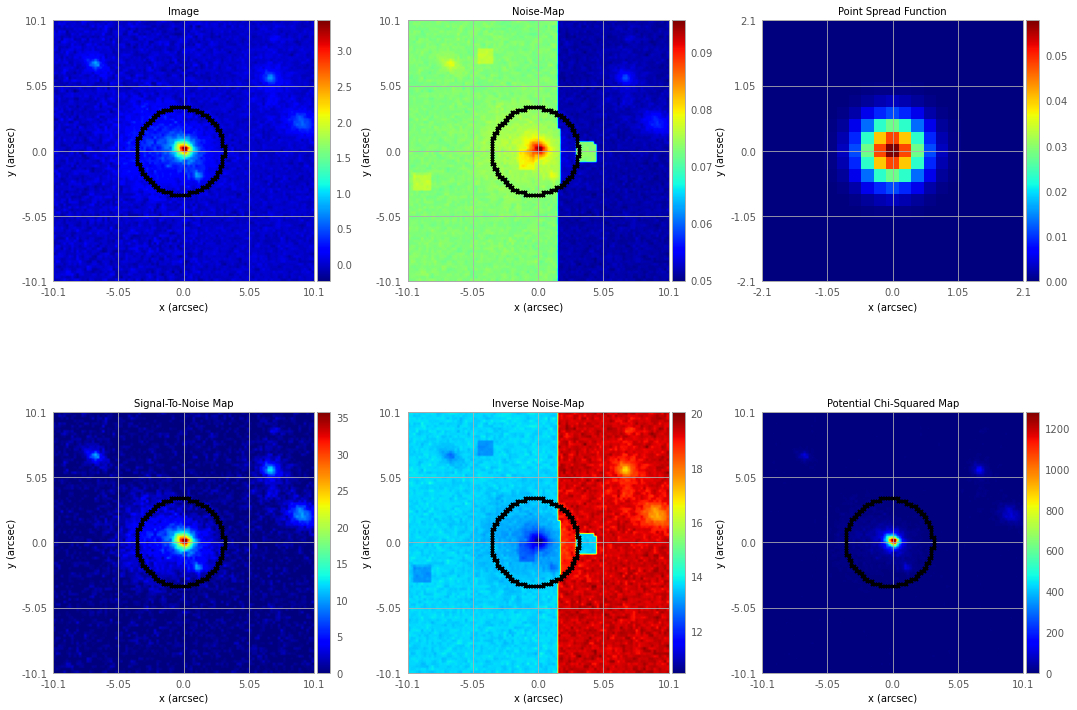

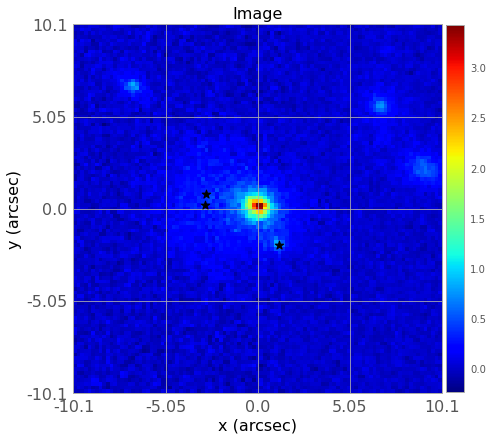

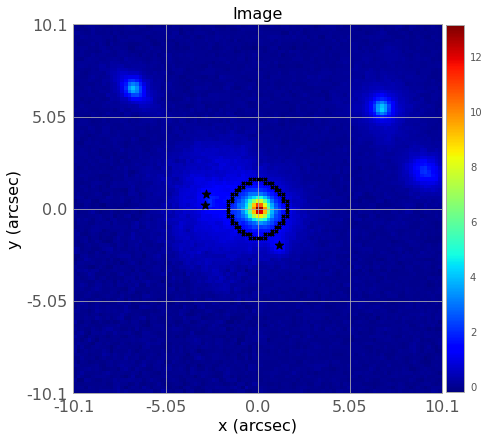

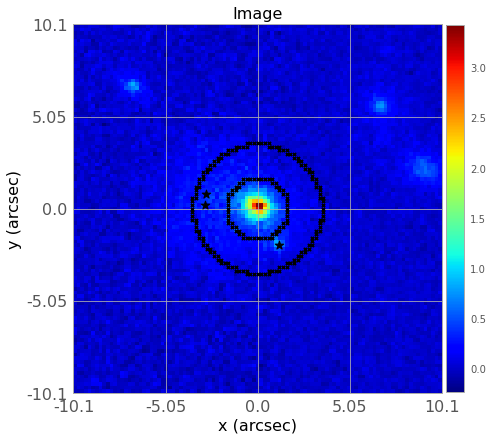

In [10]:
# load r-band imaging
imaging_r = al.Imaging.from_fits(image_path=path.join(object_folder, f'{links_id}_r_image.fits'),
                              noise_map_path=path.join(object_folder, f'{links_id}_r_noise_map_image.fits'),
                              psf_path=path.join(object_folder, f'{links_id}_r_psf_image.fits'),
                               pixel_scales=0.2)

# load g-band imaging
imaging_g = al.Imaging.from_fits(image_path=path.join(object_folder, f'{links_id}_g_image.fits'),
                              noise_map_path=path.join(object_folder, f'{links_id}_g_noise_map_image.fits'),
                              psf_path=path.join(object_folder, f'{links_id}_g_psf_image.fits'),
                               pixel_scales=0.2)

# set up masks
mask = al.Mask2D.from_fits(f'{object_folder}{links_id}_g_mask.fits', pixel_scales=imaging_r.pixel_scales)
lens_mask = al.Mask2D.from_fits(f'{object_folder}{links_id}_r_lens_mask.fits', pixel_scales=imaging_r.pixel_scales)
source_mask = al.Mask2D.from_fits(f'{object_folder}{links_id}_g_source_mask.fits', pixel_scales=imaging_r.pixel_scales)

# plot subplots for first view
print('Plotting r-band')
imaging_plotter_r = aplt.ImagingPlotter(
    imaging=imaging_r, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter_r.subplot_imaging()

print('Plotting g-band')
imaging_plotter_g = aplt.ImagingPlotter( # this is where the noise is coming up weird
    imaging=imaging_g, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter_g.subplot_imaging()

# set positions
pos = np.genfromtxt(f'{object_folder}3234_r_positions_grid.csv', delimiter=',')
imaging_g.positions = al.Grid2DIrregular(
    [(pos[0], pos[1]), ( pos[2],  pos[3]), (pos[4], pos[5])]#, (-0.8, 1.0), (-1.0, 0.5), (0.3, 1.1)]
)

# plot positions g-band image
visuals_2d = aplt.Visuals2D(mask=None, positions=imaging_g.positions)
imaging_plotter_g = aplt.ImagingPlotter(imaging=imaging_g, visuals_2d=visuals_2d)
imaging_plotter_g.figures(image=True)

# plot lens mask r-band image
imaging_plotter_r = aplt.ImagingPlotter( # this is where the noise is coming up weird
    imaging=imaging_r, visuals_2d=aplt.Visuals2D(mask=lens_mask, positions=imaging_g.positions)
)
imaging_plotter_r.figures(image=True)

# plot source mask g-band image
visuals_2d = aplt.Visuals2D(mask=source_mask, positions=imaging_g.positions)
imaging_plotter_g = aplt.ImagingPlotter(imaging=imaging_g, visuals_2d=visuals_2d)
imaging_plotter_g.figures(image=True)

In [13]:
# Start a pandas dataframe
#performance_log = pd.DataFrame(columns=['Experiment', 
#                                        'phase1_time', 
#                                        'phase1_likelihood', 
#                                        'phase2_time', 
#                                        'phase2_likelihood' 
#                                        ])

# load performance log from csv
performance_log = pd.read_csv(f'{csv_path}G{gama_id}_{links_id}_performance_log.csv')
print(performance_log)
#print(performance_log)

   Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1 Experiment  phase1_time  \
0           0           0.0             0.0          1   403.158289   
1           1           0.0             NaN          2   151.080091   
2           0           NaN             NaN         2a   163.102591   

   phase1_likelihood  phase2_time  phase2_likelihood  
0         445.398771  1164.151751         163.125675  
1         469.442803  1602.797939         164.331216  
2         469.267740  2655.558353         164.223882  


Plotting r-band


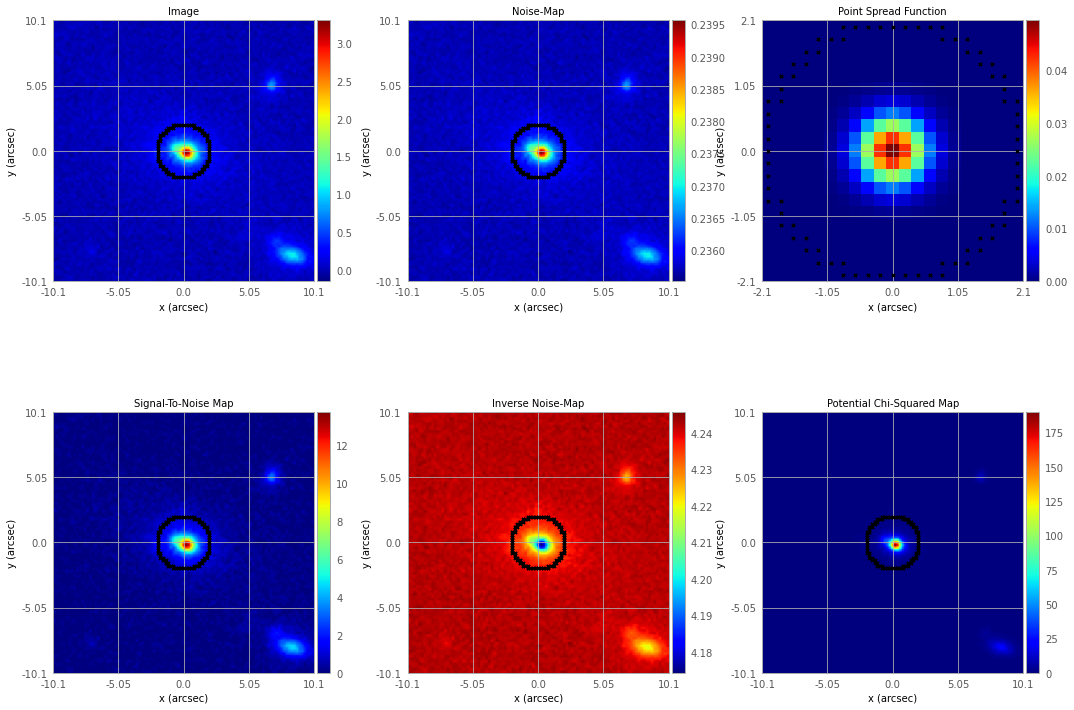

Galaxy (centre_0, UniformPrior, lower_limit = -0.4, upper_limit = 0.0), (centre_1, UniformPrior, lower_limit = 0.0, upper_limit = 0.4), (elliptical_comps_0, GaussianPrior, mean = 0.0, sigma = 0.3), (elliptical_comps_1, GaussianPrior, mean = 0.0, sigma = 0.3), (intensity, LogUniformPrior, lower_limit = 1e-06, upper_limit = 1000000.0), (effective_radius, GaussianPrior, mean = 2.1932, sigma = 0.186), (sersic_index, UniformPrior, lower_limit = 0.5, upper_limit = 8.0)


In [14]:
# set experiment number
#experiment_number = '3'

# set up grid and settings
settings_masked_imaging = al.SettingsMaskedImaging(grid_class=al.Grid2D)#, psf_shape_2d=imaging.psf.shape_2d)
settings = al.SettingsPhaseImaging(settings_masked_imaging=settings_masked_imaging)

#set up lens light profile
lens_start = al.GalaxyModel(
    redshift=zlens, bulge=al.lp.EllipticalSersic#, mass=al.mp.EllipticalIsothermal
)

lens_start.bulge.effective_radius = af.GaussianPrior(mean=re_r, sigma=re_r_err, lower_limit=0.0, upper_limit=re_r+re_r_err)
lens_start.bulge.centre_0 = af.UniformPrior(lower_limit=-0.5, upper_limit=0.5)
lens_start.bulge.centre_1 = af.UniformPrior(lower_limit=-0.5, upper_limit=0.5)


# set up phase
phase1 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix=f"{output_folder}", name=f"experiment_{experiment_number}_phase1_{datetime}", n_live_points=200,
        evidence_tolerance=0.5, walks = 10, facc=0.3
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens_start)#, source=source)
)

print(lens_start)

In [10]:
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase1_result = phase1.run(dataset=imaging_r, mask=mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

Phase running...


INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.
INFO:root:No Dynesty samples found, beginning new non-linear search. 
529it [00:13, 38.88it/s, +200 | bound: 0 | nc: 1 | ncall: 2706 | eff(%): 26.940 | loglstar:   -inf < 334.231 <    inf | logz: 325.610 +/-    nan | dlogz:  1.089 >  0.500]     
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
685it [00:13, 50.62it/s, +200 | bound: 0 | nc: 1 | ncall: 5262 | eff(%): 16.819 | loglstar:   -inf < 334.231 <    inf | logz: 324.832 +/-    nan | dlogz:  1.089 >  0.500]  
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
764it [00:12, 14.54it/s, bound: 1 | nc: 10 | ncall: 7647 | eff(%):  9.991 | loglstar:   -inf < -134.380 <    inf | logz: -142.551 +/-    nan | dlogz: 491.793 >  0.500]  /soft/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely i

Work complete! Took us 403.15828935429454 seconds or 6.7193048225715755 minutes.


Log likelihood: 445.39877054445685
Model: Galaxy (centre_0, GaussianPrior, mean = -0.09456661067053622, sigma = 0.05), (centre_1, GaussianPrior, mean = 0.09776432237008913, sigma = 0.05), (elliptical_comps_0, GaussianPrior, mean = -0.1349046981495257, sigma = 0.2), (elliptical_comps_1, GaussianPrior, mean = 0.1863827244225051, sigma = 0.2), (intensity, GaussianPrior, mean = 0.16078572954436132, sigma = 0.08039286477218066), (effective_radius, GaussianPrior, mean = 2.3616593399676726, sigma = 2.3616593399676726), (sersic_index, GaussianPrior, mean = 3.544184329289555, sigma = 1.5), None, None


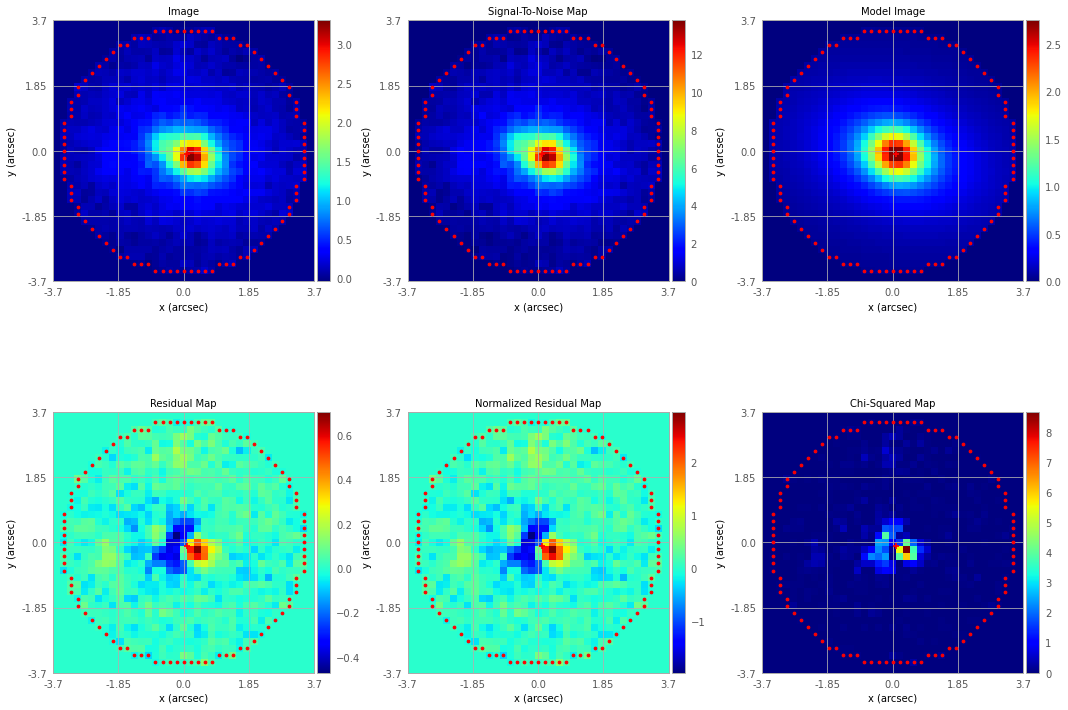

In [11]:
# write the results to the log
print(f'Log likelihood: {phase1_result.log_likelihood}')
print(f'Model: {phase1_result.model}')

phase1_time = tock-tick

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase1_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()


In [22]:
# now phase 2!

#set up lens and source

# set stellar mass profile
mass = al.mp.EllipticalIsothermal
#mass.take_attributes(source=phase1_result.model.galaxies.lens.bulge)

# set dark profile
dark = af.PriorModel(al.mp.SphericalNFWMCRLudlow)
dark.mass_at_200 = af.LogUniformPrior(lower_limit=1e8, upper_limit=1e15)
dark.redshift_object = zlens
dark.redshift_source = zsource

lens = al.GalaxyModel(
    redshift=zlens, mass=mass, dark=dark
)

source = al.GalaxyModel(
    redshift=zsource, bulge=al.lp.SphericalExponential)

# make lens intensity default to 0.1 +- 0.1 because red to green makes it wonky
#lens.bulge.intensity = af.GaussianPrior(mean=0.1, sigma=0.1)

# set uniform m_l ratio
#lens.bulge.mass_to_light_ratio = af.UniformPrior(lower_limit=0.0, upper_limit=100000.0) # leave it default

# fix stellar mass center and source mask center
lens.mass.centre = phase1_result.instance.galaxies.lens.bulge.centre
source_mask.centre =lens.mass.centre

# fix lens elliptical comps
lens.mass.elliptical_comps = phase1_result.instance.galaxies.lens.bulge.elliptical_comps

# einstein radius
#lens.mass.einstein_radius = af.GaussianPrior(mean=einstein_radius, sigma=0.5*einstein_radius) # take sigma to be 50% of mean # hmmm

# source position
source.bulge.centre_0 = af.UniformPrior(lower_limit=-5, upper_limit=5)
source.bulge.centre_1 = af.UniformPrior(lower_limit=-5, upper_limit=5)
source.bulge.effective_radius = af.UniformPrior(lower_limit=0.0, upper_limit=5.0)
#source.bulge.intensity = af.UniformPrior(lower_limit=0.0, upper_limit=10*lens.bulge.intensity)

print(f'Lens: {lens}')
print(f'Source: {source}')

Lens: Galaxy (elliptical_comps_0, GaussianPrior, mean = -0.1349046981495257, sigma = 0.2), (elliptical_comps_1, GaussianPrior, mean = 0.1863827244225051, sigma = 0.2), (intensity, GaussianPrior, mean = 0.16078572954436132, sigma = 0.08039286477218066), (effective_radius, GaussianPrior, mean = 1.9137, sigma = 0.1999), (sersic_index, GaussianPrior, mean = 3.544184329289555, sigma = 1.5), (mass_to_light_ratio, LogUniformPrior, lower_limit = 1e-06, upper_limit = 1000000.0), (mass_at_200, LogUniformPrior, lower_limit = 100000000.0, upper_limit = 1000000000000000.0)
Source: Galaxy (centre_0, UniformPrior, lower_limit = -3.0, upper_limit = 3.0), (centre_1, UniformPrior, lower_limit = -3.0, upper_limit = 3.0), (intensity, LogUniformPrior, lower_limit = 1e-06, upper_limit = 1000000.0), (effective_radius, UniformPrior, lower_limit = 0.0, upper_limit = 5.0)


In [39]:
# set the settings to include the positions
settings_lens = al.SettingsLens(positions_threshold=1.0)

settings = al.SettingsPhaseImaging(
    settings_masked_imaging=settings_masked_imaging, settings_lens=settings_lens
)

In [40]:
# set up phase
phase2 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix=f'{output_folder}', name=f"experiment_{experiment_number}_phase2_fit_{datetime}", n_live_points=300,
        evidence_tolerance=0.5, walks=10, facc=0.3
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens, source=source)#, source=source)
)

In [42]:
# run phase
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase2_result = phase2.run(dataset=imaging_g, mask=source_mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.


Phase running...


INFO:root:No Dynesty samples found, beginning new non-linear search. 
530it [02:42,  3.25it/s, +200 | bound: 0 | nc: 1 | ncall: 2711 | eff(%): 26.927 | loglstar:   -inf < 162.311 <    inf | logz: 156.338 +/- 94.781 | dlogz:  0.130 >  0.250]   
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
664it [03:10,  3.48it/s, +200 | bound: 0 | nc: 1 | ncall: 5239 | eff(%): 16.492 | loglstar:   -inf < 162.365 <    inf | logz: 156.540 +/- 94.780 | dlogz:  0.060 >  0.250]
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).
772it [02:41,  4.78it/s, +200 | bound: 2 | nc: 1 | ncall: 7741 | eff(%): 12.557 | loglstar:   -inf < 162.365 <    inf | logz: 156.555 +/- 94.780 | dlogz:  0.035 >  0.250]
INFO:root:10000 Iterations: Performing update (Visualization, outputting samples, etc.).
1018it [02:43,  6.24it/s, +200 | bound: 11 | nc: 1 | ncall: 10249 | eff(%): 11.884 | loglstar:   -inf < 163.063 <    inf | logz: 156.749 +/- 94.780 |

Work complete! Took us 1164.151751268655 seconds or 19.402529187810917 minutes.


In [ ]:
# write the results to the log
print(f'Log likelihood: {phase2_result.log_likelihood}')
print(f'Model: {phase2_result.model}')

phase2_time=tock-tick

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase2_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

In [22]:
# now phase 3!

#update mask to be centered on lens
mask.centre = phase1_result.model.galaxies.lens.bulge.centre

#set up lens and source

# set stellar mass/light profile
bulge = af.PriorModel(al.lmp.EllipticalSersic)
bulge.take_attributes(source=phase1_result.model.galaxies.lens.bulge)

# set dark matter profile
dark = af.PriorModel(al.mp.SphericalNFWMCRLudlow)
dark.take_attributes(source=phase2_result.model.galaxies.lens.dark)

lens = al.GalaxyModel(
    redshift=zlens, bulge=bulge, dark=dark
)

source_bulge = af.PriorModel(al.lp.SphericalExponential)
source_bulge.take_attributes(source=phase2_result.model.galaxies.source.bulge)

source = al.GalaxyModel(
    redshift=zsource, bulge=source_bulge)

# make lens intensity default to 0.1 +- 0.1 because red to green makes it wonky
#lens.bulge.intensity = af.GaussianPrior(mean=0.1, sigma=0.1)

# set uniform m_l ratio
#lens.bulge.mass_to_light_ratio = af.UniformPrior(lower_limit=0.0, upper_limit=100000.0) # leave it default

# make dark matter centered at stellar mass center
lens.bulge.centre = phase1_result.instance.galaxies.lens.bulge.centre
lens.dark.centre = lens.bulge.centre

# make lens effective radius for g-band
lens.bulge.effective_radius = af.GaussianPrior(mean=re_g, sigma=re_g_err, lower_limit=0.0, upper_limit=re_g+re_g_err)

# einstein radius
#lens.mass.einstein_radius = af.GaussianPrior(mean=einstein_radius, sigma=0.3*einstein_radius) # take sigma to be 30% of mean # hmmm

#source.bulge.intensity = af.UniformPrior(lower_limit=0.0, upper_limit=10*lens.bulge.intensity)

print(f'Lens: {lens}')
print(f'Source: {source}')

Lens: Galaxy (elliptical_comps_0, GaussianPrior, mean = -0.1349046981495257, sigma = 0.2), (elliptical_comps_1, GaussianPrior, mean = 0.1863827244225051, sigma = 0.2), (intensity, GaussianPrior, mean = 0.16078572954436132, sigma = 0.08039286477218066), (effective_radius, GaussianPrior, mean = 1.9137, sigma = 0.1999), (sersic_index, GaussianPrior, mean = 3.544184329289555, sigma = 1.5), (mass_to_light_ratio, LogUniformPrior, lower_limit = 1e-06, upper_limit = 1000000.0), (mass_at_200, LogUniformPrior, lower_limit = 100000000.0, upper_limit = 1000000000000000.0)
Source: Galaxy (centre_0, UniformPrior, lower_limit = -3.0, upper_limit = 3.0), (centre_1, UniformPrior, lower_limit = -3.0, upper_limit = 3.0), (intensity, LogUniformPrior, lower_limit = 1e-06, upper_limit = 1000000.0), (effective_radius, UniformPrior, lower_limit = 0.0, upper_limit = 5.0)


In [39]:
# set the settings to include the positions
settings_lens = al.SettingsLens(positions_threshold=1.0)

settings = al.SettingsPhaseImaging(
    settings_masked_imaging=settings_masked_imaging, settings_lens=settings_lens
)

In [40]:
# set up phase
phase3 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix=f'{output_folder}', name=f"experiment_{experiment_number}_phase3_fit_{datetime}", n_live_points=500,
        evidence_tolerance=0.25, walks=10, facc=0.3
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens, source=source)#, source=source)
)

In [42]:
# run phase
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase3_result = phase3.run(dataset=imaging_g, mask=mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.


Phase running...


INFO:root:No Dynesty samples found, beginning new non-linear search. 
530it [02:42,  3.25it/s, +200 | bound: 0 | nc: 1 | ncall: 2711 | eff(%): 26.927 | loglstar:   -inf < 162.311 <    inf | logz: 156.338 +/- 94.781 | dlogz:  0.130 >  0.250]   
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
664it [03:10,  3.48it/s, +200 | bound: 0 | nc: 1 | ncall: 5239 | eff(%): 16.492 | loglstar:   -inf < 162.365 <    inf | logz: 156.540 +/- 94.780 | dlogz:  0.060 >  0.250]
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).
772it [02:41,  4.78it/s, +200 | bound: 2 | nc: 1 | ncall: 7741 | eff(%): 12.557 | loglstar:   -inf < 162.365 <    inf | logz: 156.555 +/- 94.780 | dlogz:  0.035 >  0.250]
INFO:root:10000 Iterations: Performing update (Visualization, outputting samples, etc.).
1018it [02:43,  6.24it/s, +200 | bound: 11 | nc: 1 | ncall: 10249 | eff(%): 11.884 | loglstar:   -inf < 163.063 <    inf | logz: 156.749 +/- 94.780 |

Work complete! Took us 1164.151751268655 seconds or 19.402529187810917 minutes.


In [43]:
# write the results to the log
print(f'Log likelihood: {phase3_result.log_likelihood}')
print(f'Model: {phase3_result.model}')

phase3_time=tock-tick

log = open(f"{output_folder}experiment_log", 'a') # append the log
lines = [f'Experiment {experiment_number} \n',
         f'Phase 1 \n',
         f'Time to convergence: {phase1_time} seconds \n', 
         f'Log likelihood: {phase1_result.log_likelihood} \n',
         f'Model: {str(phase1_result.model)} \n',
         f'Phase 2 \n',
         f'Time to convergence: {phase2_time} seconds \n', 
         f'Log likelihood: {phase2_result.log_likelihood} \n', 
         f'Model: {str(phase2_result.model)} \n',
         f'Phase 3 \n',
         f'Time to convergence: {phase3_time} seconds \n', 
         f'Log likelihood: {phase3_result.log_likelihood} \n', 
         f'Model: {str(phase3_result.model)} \n','\n'] # set lines to write the model result
log.writelines(lines) # write lines
log.close()

Log likelihood: 163.12567460341367
Model: Galaxy (elliptical_comps_0, GaussianPrior, mean = -0.12091435428141925, sigma = 0.3834496602337272), (elliptical_comps_1, GaussianPrior, mean = 0.2343720367847074, sigma = 0.40316819858068653), (intensity, GaussianPrior, mean = 0.05327837349927905, sigma = 0.053457071609182116), (effective_radius, GaussianPrior, mean = 1.8721355646722821, sigma = 1.8721355646722821), (sersic_index, GaussianPrior, mean = 2.579741735636044, sigma = 3.288079141762924), (mass_to_light_ratio, GaussianPrior, mean = 181.8572165584121, sigma = 876600.6750142531), (mass_at_200, GaussianPrior, mean = 648246628092.3497, sigma = 855339469584063.2), Galaxy (centre_0, GaussianPrior, mean = 0.17950319923088398, sigma = 3.1452481122322196), (centre_1, GaussianPrior, mean = -0.2460993764355576, sigma = 3.200838299782494), (intensity, GaussianPrior, mean = 0.0032364826225853866, sigma = 497809.84392553405), (effective_radius, GaussianPrior, mean = 2.6099664545813908, sigma = 2.6

  Experiment  phase1_time  phase1_likelihood  phase2_time  phase2_likelihood
0          1   403.158289         445.398771  1164.151751         163.125675


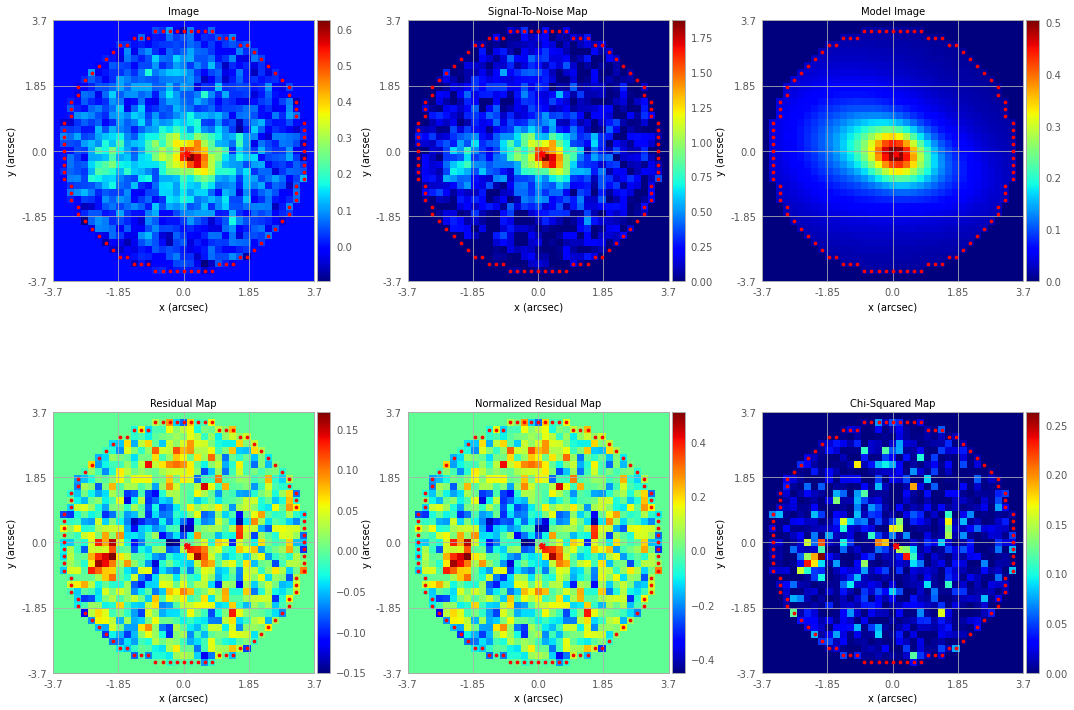

In [44]:
# append performance log
data_list = [[experiment_number, 
            phase1_time,
            phase1_result.log_likelihood,
            phase2_time, 
            phase2_result.log_likelihood,
            phase3_time, 
            phase3_result.log_likelihood,
             ]]
new_dataframe_entry = pd.DataFrame(data_list,
                                  columns=['Experiment', 
                                           'phase1_time', 
                                           'phase1_likelihood', 
                                           'phase2_time', 
                                           'phase2_likelihood',
                                           'phase3_time', 
                                           'phase3_likelihood'
                                           ])
performance_log = pd.concat([performance_log, new_dataframe_entry])
print(performance_log)
performance_log.to_csv(f'{csv_path}G{gama_id}_{links_id}_performance_log.csv')
#print(phase_result.model)
# get samples to see how it ran?
#log_likelihoods = phase_result.samples.log_likelihoods
#x = np.arange(0, len(log_likelihoods), 1)
#plt.plot(x[500:], log_likelihoods[500:])
#plt.xlim()

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase3_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()